In [64]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from models import *

In [65]:
# Create points
p1 = Point(100, 100)
p2 = Point(300, 300)

In [66]:
# Create a line
line = Line(p1, p2)

In [67]:
print(p1)
print(p2)
print(line)
print("Line length:", line.length())

Point(x=100, y=100)
Point(x=300, y=300)
Line(start_point=Point(x=100, y=100), end_point=Point(x=300, y=300))
Line length: 282.842712474619


In [68]:
# Generate a blank image
blank_image = np.zeros((400, 400, 3), dtype=np.uint8)

In [69]:
# Draw the line on the image
line.draw(blank_image, color=(255, 255, 255), thickness=3)

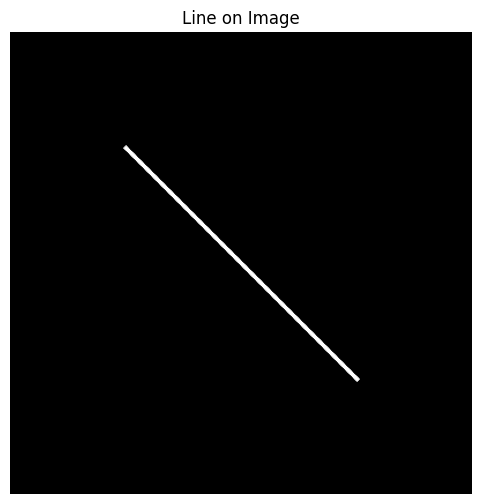

In [70]:
# Display the image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB))
plt.title("Line on Image")
plt.axis("off")
plt.show()

In [71]:
def generate_road_lines(image_width=800, image_height=600, lane_width=100):
    """
    Generate lines representing a bird's-eye view of a road.
    """
    center_x = image_width // 2
    top_y = 0
    bottom_y = image_height

    # Create the lane boundary lines
    left_line = Line(Point(center_x - lane_width, top_y), Point(center_x - lane_width, bottom_y))
    right_line = Line(Point(center_x + lane_width, top_y), Point(center_x + lane_width, bottom_y))

    # Create the dashed center line
    dash_length = 40
    gap_length = 20
    center_line_segments = []
    for y in range(0, image_height, dash_length + gap_length):
        start = Point(center_x, y)
        end = Point(center_x, min(y + dash_length, image_height))
        center_line_segments.append(Line(start, end))

    return left_line, right_line, center_line_segments

In [72]:
def draw_road_from_lines(image_size=(800, 600), lane_width=100):
    """
    Generate and draw the road using lines.
    """
    # Create a blank black image
    image = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)

    # Generate road lines
    left_line, right_line, center_line_segments = generate_road_lines(image_size[0], image_size[1], lane_width)

    # Draw the lines on the image
    left_line.draw(image, color=(255, 255, 255), thickness=5)
    right_line.draw(image, color=(255, 255, 255), thickness=5)
    for segment in center_line_segments:
        segment.draw(image, color=(255, 255, 255), thickness=5)

    return image

In [73]:
# Example usage in Jupyter
road_image = draw_road_from_lines(image_size=(800, 600), lane_width=100)

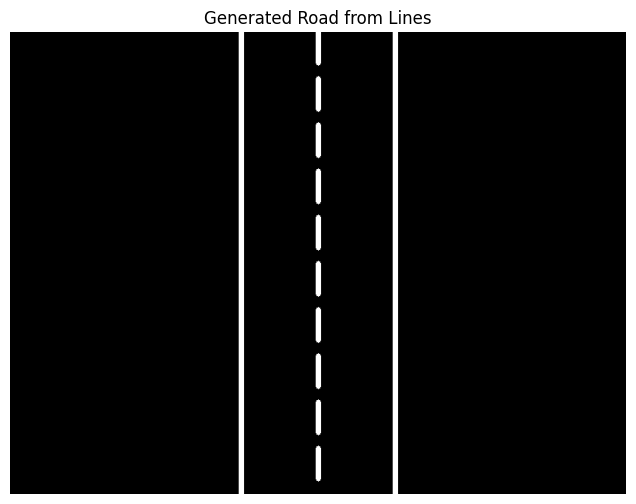

In [74]:
# Display the image using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(road_image, cv2.COLOR_BGR2RGB))
plt.title("Generated Road from Lines")
plt.axis("off")
plt.show()

In [75]:
def apply_perspective_transform(image, src_points, dst_points, output_size):
    """
    Apply a perspective transformation to the image.

    Parameters:
        image (numpy.ndarray): Input image to transform.
        src_points (list[Point]): Source points as Point objects.
        dst_points (list[Point]): Destination points as Point objects.
        output_size (tuple): Size of the output image (width, height).

    Returns:
        numpy.ndarray: Transformed image.
    """
    # Convert Point objects to numpy arrays
    src_array = np.float32([p.to_tuple() for p in src_points])
    dst_array = np.float32([p.to_tuple() for p in dst_points])
    
    # Compute the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(src_array, dst_array)
    
    # Apply the perspective transformation
    transformed_image = cv2.warpPerspective(image, matrix, output_size)
    return transformed_image


In [76]:
# Generate the bird's-eye view road image
birdseye_image = draw_road_from_lines(image_size=(800, 600), lane_width=100)

In [77]:
# These represent the corners of the road as seen from above
src_points = [
    Point(300, 0),  # Top-left corner (beginning of the road)
    Point(500, 0),  # Top-right corner (beginning of the road)
    Point(700, 600), # Bottom-right corner (end of the road)
    Point(100, 600)  # Bottom-left corner (end of the road)
]

In [78]:
# Define the destination points (simulating a new perspective as if standing on the road)
dst_points = [
    Point(350, 0),   # Start of the road (slightly to the right for a more realistic viewpoint)
    Point(450, 0),   # Start of the road (slightly to the left)
    Point(700, 600), # End of the road (stay the same)
    Point(100, 600)  # End of the road (stay the same)
]

In [79]:

# Apply the perspective transformation
output_size = (800, 600)  # Output image size
transformed_image = apply_perspective_transform(birdseye_image, src_points, dst_points, output_size)


In [80]:
# Display the original and transformed images
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

(-0.5, 799.5, 599.5, -0.5)

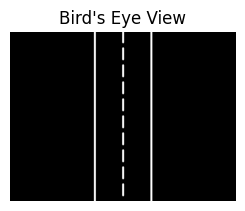

In [81]:
# Bird's-eye view
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(birdseye_image, cv2.COLOR_BGR2RGB))
plt.title("Bird's Eye View")
plt.axis("off")

(-0.5, 799.5, 599.5, -0.5)

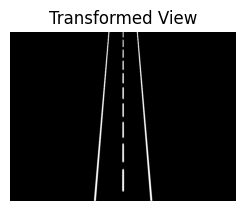

In [82]:
# Transformed perspective
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title("Transformed View")
plt.axis("off")

In [83]:
plt.show()

In [84]:
# Function to simulate the perspective of lane lines converging at the horizon
def transform_road_view_with_convergence(source_points, road_image, shift_x=0):
    # Adjust the destination points to simulate forward motion and convergence at the horizon
    horizon_offset = 600  # Simulate the horizon (far in the distance)
    destination_points = np.array([
        [source_points[0][0] + shift_x, source_points[0][1]],   # Move left to right
        [source_points[1][0] + shift_x, source_points[1][1]],   # Move left to right
        [source_points[2][0] + shift_x, source_points[2][1] + horizon_offset],  # Converge at horizon
        [source_points[3][0] + shift_x, source_points[3][1] + horizon_offset]   # Converge at horizon
    ], dtype='float32')

    # Calculate the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(source_points, destination_points)

    # Apply the perspective transformation to simulate motion along the road with lane convergence
    transformed_image = cv2.warpPerspective(road_image, matrix, (800, 700))
    
    return transformed_image

In [85]:
# Corrected function for generating first-person perspective where lane lines converge at the horizon
def simulate_first_person_with_convergence(source_points, road_image, shift_x_start, shift_x_end, num_frames=5):
    # Generate images simulating the first-person perspective with lane lines converging to the horizon
    images = []
    for i in range(num_frames):
        shift_x = shift_x_start + (shift_x_end - shift_x_start) * (i / (num_frames - 1))  # Interpolate shift_x
        # Apply the perspective transformation for each shift to simulate forward motion on the road
        transformed_image = transform_road_view_with_convergence(source_points, road_image, shift_x)
        images.append(transformed_image)
    
    return images

In [86]:
# Create the initial road image
road_image = draw_road_from_lines(image_size=(800, 600), lane_width=100)

In [87]:
# Simulate the first-person view from left to right, with lane lines converging at the horizon
shift_x_start = 0   # Start at the leftmost point
shift_x_end = 400   # End at the rightmost point
transformed_images = simulate_first_person_with_convergence(src_points, road_image, shift_x_start, shift_x_end)

TypeError: 'Point' object is not subscriptable

In [ ]:
# Plot the images
fig, axes = plt.subplots(1, len(transformed_images), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(transformed_images[i])
    ax.axis('off')
    ax.set_title(f"Frame {i+1}")
plt.tight_layout()
plt.show()